## Importing required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

## Loading the MNIST dataset

In [2]:
# We are using fetch_openml to load the MNIST dataset
# The dataset contains 70,000 samples with 784 features (28x28 images flattened).
mnist = fetch_openml('mnist_784', version=1, parser='auto')

# Extract data (features) and target labels
X = mnist.data.astype('float32')  # shape: (70000, 784)
y = mnist.target.astype(int)      # Converting labels from string to integer

## Normalization of the data

In [3]:
# Normalize the pixel values from [0, 255] to [0, 1]
X /= 255.0

In [4]:
# Printing the shape of the dataset
print("Data shape (samples x features):", X.shape)
print("Labels shape:", y.shape)

Data shape (samples x features): (70000, 784)
Labels shape: (70000,)


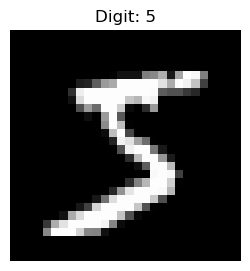

In [5]:
# Displaying a sample image (first image in the dataset)
plt.figure(figsize=(3, 3))
plt.imshow(X.iloc[0].values.reshape(28, 28), cmap='gray')
plt.title(f"Digit: {y.iloc[0]}")
plt.axis('off')
plt.show()

# PCA Implementation

In [6]:
import numpy as np

def pca_from_scratch(X, n_components=2):
    # Converting DataFrame to NumPy array 
    if hasattr(X, 'values'):
        X = X.values

    # Step 1: Center the data (subtract the mean)
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    # Step 2: Compute the covariance matrix - rows are samples, columns are features
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Step 3: Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Step 4: Sort the eigenvalues and eigenvectors in descending order
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_index]
    sorted_eigenvectors = eigenvectors[:, sorted_index]
    
    # Step 5: Select the top n_components eigenvectors
    eigenvector_subset = sorted_eigenvectors[:, :n_components]
    
    # Step 6: Transform the data i.e. projecting onto the new subspace
    X_reduced = np.dot(X_centered, eigenvector_subset)
    return X_reduced, sorted_eigenvalues, eigenvector_subset


X_pca_custom, eigenvalues, eigenvectors = pca_from_scratch(X, n_components=2)
print("Custom PCA output shape:", X_pca_custom.shape)

Custom PCA output shape: (70000, 2)


# t-SNE Implementation

In [7]:
from sklearn.manifold import TSNE

# For demonstration,taking the first 10000 samples to speed up t-SNE computation
subset_size = 10000
X_subset = X.iloc[:subset_size].values  # converting subset to NumPy array
y_subset = y.iloc[:subset_size]

# Creating a t-SNE instance to reduce data to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

print("t-SNE output shape:", X_tsne.shape)

t-SNE output shape: (10000, 2)


# Auto-Encoder Implementation

In [8]:
# Convert the DataFrame X to a NumPy array for processing
X_np = X.values

# Define a deep autoencoder class with Adam optimizer
class DeepAutoencoder:
    def __init__(self, learning_rate=0.001, epochs=50, batch_size=256, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Set training hyperparameters
        self.lr = learning_rate       # Learning rate for gradient descent
        self.epochs = epochs          # Number of epochs to train
        self.batch_size = batch_size  # Batch size for training
        self.beta1 = beta1            # Adam optimizer parameter (momentum)
        self.beta2 = beta2            # Adam optimizer parameter (RMSprop term)
        self.epsilon = epsilon        # Small constant for numerical stability
 
        # Initialize weights and biases for the encoder and decoder
        # Encoder: input 784 -> 128 -> 64 -> 2 (latent space)
        self.W1 = self.init_weights(784, 128)
        self.b1 = np.zeros((1, 128))
        self.W2 = self.init_weights(128, 64)
        self.b2 = np.zeros((1, 64))
        self.W3 = self.init_weights(64, 2)
        self.b3 = np.zeros((1, 2))
 
        # Decoder: latent 2 -> 64 -> 128 -> 784 (reconstructed image)
        self.W4 = self.init_weights(2, 64)
        self.b4 = np.zeros((1, 64))
        self.W5 = self.init_weights(64, 128)
        self.b5 = np.zeros((1, 128))
        self.W6 = self.init_weights(128, 784)
        self.b6 = np.zeros((1, 784))
 
        # Initialize Adam optimizer states for each parameter (first moment m and second moment v)
        self.opt = {}
        for name in ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5', 'W6', 'b6']:
            self.opt[f"m_{name}"] = 0
            self.opt[f"v_{name}"] = 0
 
    def init_weights(self, fan_in, fan_out):
        # Use Glorot (Xavier) uniform initialization to set weights between -limit and limit
        limit = np.sqrt(6 / (fan_in + fan_out))
        return np.random.uniform(-limit, limit, (fan_in, fan_out))
 
    def relu(self, x):
        # ReLU activation function
        return np.maximum(0, x)
 
    def relu_derivative(self, x):
        # Derivative of ReLU: 1 if x > 0, else 0
        return (x > 0).astype(float)
 
    def sigmoid(self, x):
        # Sigmoid activation function with clipping to avoid numerical issues
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
 
    def sigmoid_derivative(self, x):
        # Derivative of sigmoid given output x (where x is sigmoid(x))
        return x * (1 - x)
 
    def adam_update(self, param, dparam, name, t):
        # Adam update for a given parameter
        # Update the first moment (m) and second moment (v)
        m = self.opt[f"m_{name}"] = self.beta1 * self.opt[f"m_{name}"] + (1 - self.beta1) * dparam
        v = self.opt[f"v_{name}"] = self.beta2 * self.opt[f"v_{name}"] + (1 - self.beta2) * (dparam ** 2)
 
        # Bias-corrected estimates
        m_hat = m / (1 - self.beta1 ** t)
        v_hat = v / (1 - self.beta2 ** t)
 
        # Update the parameter using Adam formula
        return param - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
 
    def fit(self, X):
        m = X.shape[0]  # Number of training samples
        t = 1           # Timestep for Adam updates
 
        # Training loop over epochs
        for epoch in range(self.epochs):
            # Shuffle the training data at the start of each epoch
            perm = np.random.permutation(m)
            X_shuffled = X[perm]
 
            # Process mini-batches
            for i in range(0, m, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
 
                # --- Forward Pass: Encoder ---
                Z1 = np.dot(X_batch, self.W1) + self.b1    # Linear transformation for first layer
                A1 = self.relu(Z1)                         # Apply ReLU activation
                Z2 = np.dot(A1, self.W2) + self.b2           # Second layer linear transformation
                A2 = self.relu(Z2)                         # ReLU activation
                Z3 = np.dot(A2, self.W3) + self.b3           # Third layer (latent layer)
                A3 = Z3  # Latent representation (using linear activation)
 
                # --- Forward Pass: Decoder ---
                Z4 = np.dot(A3, self.W4) + self.b4           # First decoder layer
                A4 = self.relu(Z4)                         # ReLU activation
                Z5 = np.dot(A4, self.W5) + self.b5           # Second decoder layer
                A5 = self.relu(Z5)                         # ReLU activation
                Z6 = np.dot(A5, self.W6) + self.b6           # Final decoder layer
                A6 = self.sigmoid(Z6)                      # Sigmoid activation for output (scaled [0,1])
 
                # Compute Loss (Mean Squared Error between input and reconstruction)
                loss = np.mean((X_batch - A6) ** 2)
 
                # --- Backward Pass ---
                # Compute gradient at the output layer: derivative of MSE loss combined with sigmoid derivative
                dA6 = (A6 - X_batch) * self.sigmoid_derivative(A6)
                dW6 = np.dot(A5.T, dA6)
                db6 = np.sum(dA6, axis=0, keepdims=True)
 
                # Propagate gradients to previous layers using chain rule
                dA5 = np.dot(dA6, self.W6.T) * self.relu_derivative(A5)
                dW5 = np.dot(A4.T, dA5)
                db5 = np.sum(dA5, axis=0, keepdims=True)
 
                dA4 = np.dot(dA5, self.W5.T) * self.relu_derivative(A4)
                dW4 = np.dot(A3.T, dA4)
                db4 = np.sum(dA4, axis=0, keepdims=True)
 
                dA3 = np.dot(dA4, self.W4.T)
                dW3 = np.dot(A2.T, dA3)
                db3 = np.sum(dA3, axis=0, keepdims=True)
 
                dA2 = np.dot(dA3, self.W3.T) * self.relu_derivative(A2)
                dW2 = np.dot(A1.T, dA2)
                db2 = np.sum(dA2, axis=0, keepdims=True)
 
                dA1 = np.dot(dA2, self.W2.T) * self.relu_derivative(A1)
                dW1 = np.dot(X_batch.T, dA1)
                db1 = np.sum(dA1, axis=0, keepdims=True)
 
                # --- Adam Updates for each parameter ---
                # Loop through each parameter and update using our custom Adam implementation
                for param, dparam, name in [
                    (self.W1, dW1, 'W1'), (self.b1, db1, 'b1'),
                    (self.W2, dW2, 'W2'), (self.b2, db2, 'b2'),
                    (self.W3, dW3, 'W3'), (self.b3, db3, 'b3'),
                    (self.W4, dW4, 'W4'), (self.b4, db4, 'b4'),
                    (self.W5, dW5, 'W5'), (self.b5, db5, 'b5'),
                    (self.W6, dW6, 'W6'), (self.b6, db6, 'b6')
                ]:
                    # Divide gradient by batch size and update parameter
                    updated = self.adam_update(param, dparam / self.batch_size, name, t)
                    # Use exec to update the parameter in the object (alternative: store parameters in a dictionary)
                    exec(f"self.{name} = updated")
 
                t += 1  # Increment the timestep for Adam updates
 
            # Print reconstruction loss every 5 epochs using the first 1000 samples
            if epoch % 5 == 0:
                recon = self.reconstruct(X[:1000])
                loss_print = np.mean((X[:1000] - recon) ** 2)
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss_print:.6f}")
 
    def encode(self, X):
        # Compute the latent representation of X using the encoder part
        A1 = self.relu(np.dot(X, self.W1) + self.b1)
        A2 = self.relu(np.dot(A1, self.W2) + self.b2)
        return np.dot(A2, self.W3) + self.b3
 
    def decode(self, A3):
        # Reconstruct the input from the latent representation using the decoder
        A4 = self.relu(np.dot(A3, self.W4) + self.b4)
        A5 = self.relu(np.dot(A4, self.W5) + self.b5)
        return self.sigmoid(np.dot(A5, self.W6) + self.b6)
 
    def reconstruct(self, X):
        # Utility function to get the full autoencoder output for input X
        return self.decode(self.encode(X))

    
    
# X_np is a NumPy array of images with shape (70000, 784)
# y contains the corresponding labels with shape (70000,)
x_train = X_np    # Use the entire dataset (or you can split into training and validation)
y_train = y
 
# Create and train the deep autoencoder with specified hyperparameters
model = DeepAutoencoder(learning_rate=0.001, epochs=20)
model.fit(x_train)
 
# Encode the training data to obtain 2D latent representations
encoded_2d = model.encode(x_train)
 
# Scale the latent representations for better visualization using StandardScaler
encoded_2d = StandardScaler().fit_transform(encoded_2d)
 
# Print the shape of the latent representation (should be (70000, 2))
print("Autoencoder latent representation shape:", encoded_2d.shape)

Epoch 1/20, Loss: 0.054774
Epoch 6/20, Loss: 0.040592
Epoch 11/20, Loss: 0.037850
Epoch 16/20, Loss: 0.036445
Autoencoder latent representation shape: (70000, 2)


# Visualization for PCA

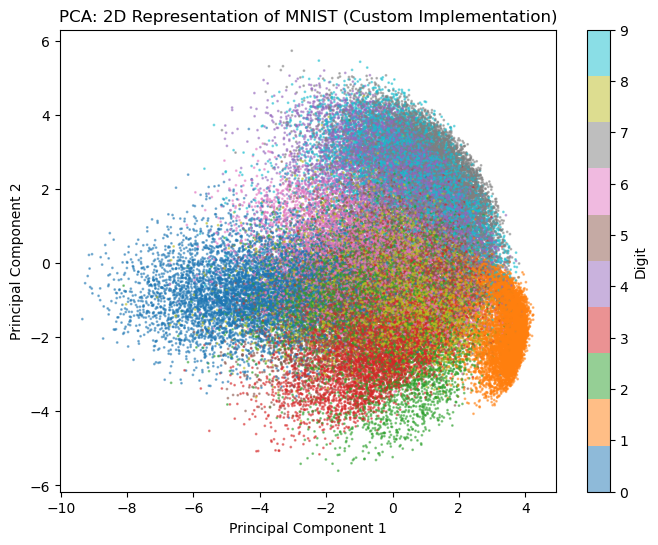

In [9]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_custom[:, 0], X_pca_custom[:, 1], c=y, cmap='tab10', s=1, alpha=0.5)
plt.title("PCA: 2D Representation of MNIST (Custom Implementation)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label("Digit")
plt.show()

# Visualization for t-SNE

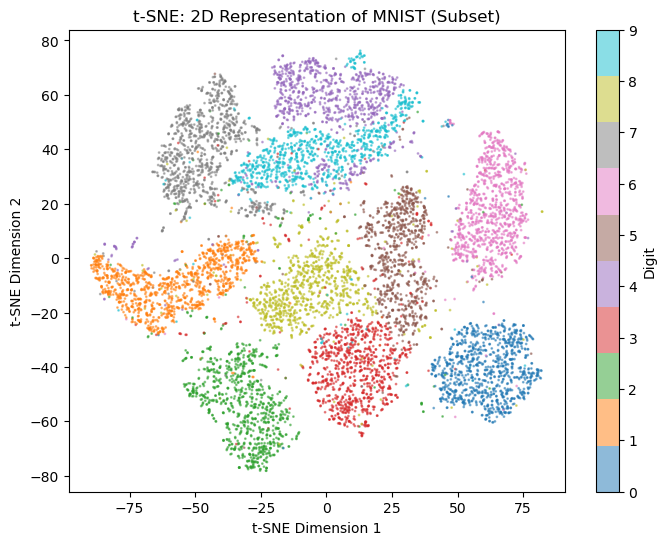

In [10]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='tab10', s=1, alpha=0.5)
plt.title("t-SNE: 2D Representation of MNIST (Subset)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label("Digit")
plt.show()

# Visualization for Auto-Encoder

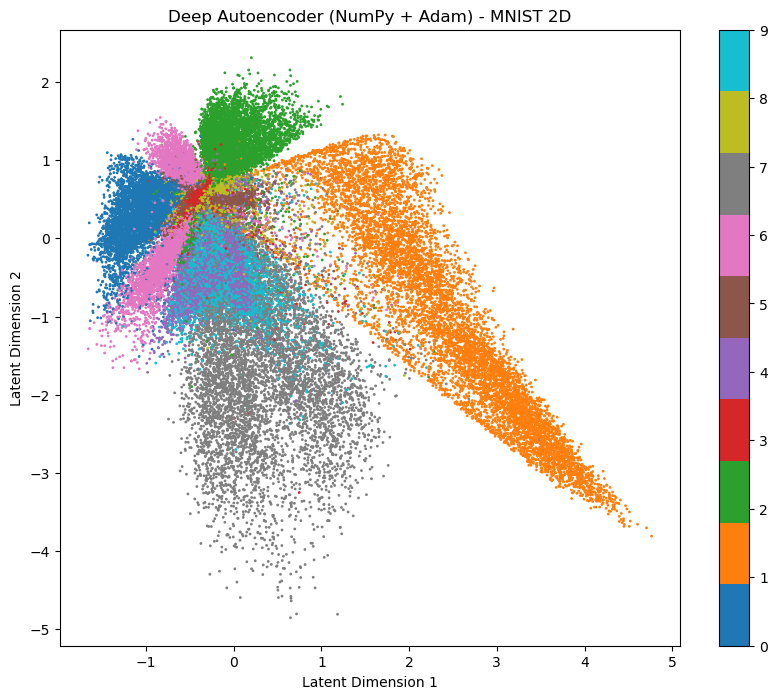

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=y_train, cmap='tab10', s=1)
plt.colorbar()
plt.title("Deep Autoencoder (NumPy + Adam) - MNIST 2D")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

# Representation Quality

## 1. PCA
- **Observations:**  
  Captures maximum variance linearly; in 2D, many digits overlap. Digits like “0” and “1” sometimes stand out.
- **Why:**  
  Global differences (e.g., “0”'s white space, “1”'s thin shape) help separation, while similar curves (e.g., “3,” “5,” “8”) lead to overlap.

## 2. t-SNE
- **Observations:**  
  Preserves local structure to form tight clusters (“islands”) for each digit, though it's computationally intensive.
- **Why:**  
  Consistent shapes (like “1” or “0”) cluster well, while similar digits may be near or slightly overlap, yet better separated than in PCA.

## 3. Auto-Encoder
- **Observations:**  
  Learns a non-linear 2D mapping, often showing a fan-like cluster pattern.
- **Why:**  
  Accurate reconstruction groups similar digits, but complex or variable digits (e.g., “2,” “5,” “8”) can be more dispersed.

## Overall Comparison
- **PCA:** Fast and interpretable but limited by linearity.  
- **t-SNE:** Excellent local clustering yet resource-intensive and sensitive to parameters.  
- **Auto-Encoder:** Flexible for non-linear data but requires careful tuning.

## Which Digits Are Better Represented?
- **Digit “1”:** Usually well-separated by all methods due to its thin, simple shape.  
- **Digit “0”:** Often distinct because of the empty center region. 
- **Digits “3,” “5,” “8,” “9”:** Commonly overlap in PCA or partially overlap in t-SNE/auto-encoder because their shapes share curves. 
- **Digit “7”/“4”:** Often form clearer clusters in t-SNE or a well-trained auto-encoder, though they can still show overlap in PCA.

# Technique Comparison

## 1. PCA

**Strengths:**
- **Fast & Efficient:** Performs well even on large datasets using linear algebra (e.g., SVD).
- **Interpretable:** Principal components are understandable and deterministic.
- **Scalable:** Can easily scale with both features and samples.

**Weaknesses:**
- **Linear Method:** Struggles to capture non-linear patterns in handwritten digits.
- **Overlapping Classes:** Often shows overlap in 2D projections, especially for similar digits.
- **Global Focus:** Captures overall variance but misses local structures.

---

## 2. t-SNE

**Strengths:**
- **Excellent Clustering:** Captures local similarities; reveals tight, well-separated digit clusters.
- **Intuitive Visualization:** Forms “island-like” groupings of digit classes.

**Weaknesses:**
- **Computationally Intensive:** Not ideal for full datasets; typically used on subsets (e.g., 5k–10k samples).
- **Sensitive to Parameters:** Output varies with perplexity and learning rate.
- **Poor Global Structure:** Good local layout, but relative positions between clusters may be misleading.

**Scalability:**  
Limited; memory and time requirements increase sharply with dataset size.

---

## 3. Auto-Encoder

**Strengths:**
- **Non-linear Capability:** Learns complex relationships in data, suitable for visualizing digits with subtle differences.
- **Flexible Architecture:** You can tailor the network to the dataset.
- **Dual Use:** Useful for both dimensionality reduction and as a feature extractor.

**Weaknesses:**
- **Requires Training:** Needs multiple epochs and hyperparameter tuning.
- **Computational Load:** Slower than PCA; better with GPU support.
- **Less Transparent:** Latent representations are harder to interpret.

**Scalability:**  
Can handle full datasets with proper tuning and hardware (e.g., GPUs).

---

## Summary

| Technique     | Strengths                                  | Weaknesses                                     | Best Use Case                      |
|---------------|---------------------------------------------|------------------------------------------------|------------------------------------|
| **PCA**        | Fast, simple, interpretable                | Linear, overlaps in 2D                         | Quick insights on full dataset     |
| **t-SNE**      | Great local clustering, tight groups       | Slow, non-scalable, parameter-sensitive        | Visualizing structure on a subset  |
| **Auto-Encoder** | Learns non-linear patterns, flexible      | Requires training, less interpretable          | Customizable deep representation   |

---

**Therefore,**  
- Use **PCA** when you need speed and broad trends.  
- Use **t-SNE** for visual insights into clustering on small data subsets.  
- Use **Auto-Encoders** when you want deep, non-linear embeddings and can afford training time.

# Interpretation

## 1. PCA

- **Linear Assumptions:**  
  PCA is a linear technique that finds the directions of maximum variance in the data. It assumes that the most significant information is along these directions.  
  - **Better Representation:**  
    - **Digit “1”:** The digit "1" is typically a thin, straight line with relatively consistent pixel intensity, which aligns well with PCA’s linear projection.  
    - **Digit “0”:** With its large, uniform background and distinct outline, "0" can be somewhat isolated along principal components.
  - **Worse Representation:**  
    - **Digits with Complex Curves (e.g., “3,” “5,” “8”):** These digits have non-linear structures and curved features that cannot be captured well by a linear projection, leading to overlapping clusters in the PCA space.

## 2. t-SNE

- **Preservation of Local Relationships:**  
  t-SNE is designed to preserve local similarities rather than global structure. It maps high-dimensional distances to a low-dimensional space in a way that nearby points remain neighbors.
  - **Better Representation:**  
    - **Digits with Consistent Local Patterns:** Digits like "1" or "0", which have consistent local pixel patterns, tend to form tight and distinct clusters because t-SNE emphasizes the similarity of neighboring points.
  - **Worse Representation:**  
    - **Digits with Subtle Variations:** Digits that have multiple styles or share similar local features (such as "3", "5", "8", and "9") may still appear close or partially overlapping because the local neighborhoods are similar, even if the overall shapes differ.

## 3. Auto-Encoder

- **Learned Non-Linear Mapping:**  
  Auto-encoders learn a non-linear function to compress and reconstruct the data. The latent space they generate reflects the features that are most useful for reconstruction.
  - **Better Representation:**  
    - **Digits with Uniform Structures:** If the network is well-trained, digits that are consistently drawn (like "1" and "0") are reconstructed accurately and tend to cluster together in the latent space.
  - **Worse Representation:**  
    - **Digits with High Variability:** Handwritten digits like "2", "5", and "8" can have significant intra-class variation. This variation makes it challenging for the auto-encoder to learn a compact representation that captures all the nuances, leading to more diffuse or overlapping clusters in the latent space.
  - **Impact of Model Tuning:**  
    - The effectiveness of the auto-encoder also depends on the network architecture, the size of the latent space, and the training process. Poor tuning might cause underfitting (where clusters are not distinct) or overfitting (where the model fails to generalize well), affecting the overall representation quality.

---

**Summary:**  
- **PCA** works well for digits with strong, linear features but struggles with non-linear, curved patterns.  
- **t-SNE** excels at revealing local structure, producing clear clusters when local pixel patterns are consistent, yet it can merge similar local structures from different digit classes.  
- **Auto-Encoders** offer a flexible, non-linear approach; however, their success largely depends on model tuning and the inherent variability within each digit class.